In [1]:
import os
import glob
import numpy as np
import pandas as pd
import random
import math
import gc
import cv2
from tqdm.auto import tqdm
import time
from functools import lru_cache
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import timm
from timm.scheduler import CosineLRScheduler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
import time

d:\anaconda\envs\class_face\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CFG = {
    'seed': 42,
    'model': 'resnet50',
    'img_size': 256,
    'epochs': 10,
    'train_bs': 32, 
    'valid_bs': 32,
    'lr': 1e-3, 
    'weight_decay': 1e-6,
    'num_workers': 8,
    'max_grad_norm' : 1000,
    'epochs_warmup' : 1.0
}

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    # 将contact_id字符串的前12位作为game_play
    df["game_play"] = df["contact_id"].str[:12]
    # 将contact_id以_划分的-3位置的数字作为step
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    # 将contact_id以_划分的-2位置的数字作为nfl_player_id_1
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    # 将contact_id以_划分的-1位置的数字作为nfl_player_id_2
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

In [5]:

# 将labels的columns做一个扩展
labels = expand_contact_id(pd.read_csv(r"E:\kaggle\nfl-plyer\baseline\nfl-player-contact-detection\nfl-player-contact-detection\input\train_labels.csv"))

train_tracking = pd.read_csv(r"E:\kaggle\nfl-plyer\baseline\nfl-player-contact-detection\nfl-player-contact-detection\input\train_player_tracking.csv")

train_helmets = pd.read_csv(r"E:\kaggle\nfl-plyer\baseline\nfl-player-contact-detection\nfl-player-contact-detection\input\train_baseline_helmets.csv")

train_video_metadata = pd.read_csv(r"E:\kaggle\nfl-plyer\baseline\nfl-player-contact-detection\nfl-player-contact-detection\input\train_video_metadata.csv")

In [6]:
# !mkdir -p ./work/frames

# import multiprocessing.dummy as mp
# from multiprocessing import Pool, cpu_count

# def do_print(video):
#     if 'Endzone2' not in video:
#         !ffmpeg -i ../input/train/{video} -r 25 -q:v 2 -f image2 ./work/frames/{video}_%04d.jpg -hide_banner -loglevel error

# if __name__=="__main__":
#     num_cpu = cpu_count()
#     p=mp.Pool(num_cpu)
#     p.map(do_print,tqdm(train_helmets.video.unique())) # range(0,1000) if you want to replicate your example
#     p.close()
#     p.join()

In [7]:
!chcp 65001
!echo 中文

Active code page: 65001
中文


In [8]:
# 包含的最关键信息就是每场比赛中运动员的接触情况
print(labels.head(1))
print('--------')
# 包含的最关键信息就是每场比赛中的每个运动员的运动轨迹
print(train_tracking.head(1))
print('--------')
# train_helmets抱哈的最关键信息就是视频视角信息及对应的运动员的位置信息
print(train_helmets.head(1))
print('--------')
print(train_video_metadata.head(1))

                   contact_id     game_play                  datetime  step  \
0  58168_003392_0_38590_43854  58168_003392  2020-09-11T03:01:48.100Z     0   

  nfl_player_id_1 nfl_player_id_2  contact  
0           38590           43854        0  
--------
      game_play  game_key  play_id  nfl_player_id                  datetime  \
0  58580_001136     58580     1136          44830  2021-10-10T21:08:20.900Z   

   step  team position  jersey_number  x_position  y_position  speed  \
0  -108  away       CB             22       61.59        42.6   1.11   

   distance  direction  orientation  acceleration    sa  
0      0.11     320.33       263.93          0.71 -0.64  
--------
      game_play  game_key  play_id     view                     video  frame  \
0  58168_003392     58168     3392  Endzone  58168_003392_Endzone.mp4    290   

   nfl_player_id player_label  left  width  top  height  
0          39947          H72   946     25  293      34  
--------
      game_play  game_key  

In [10]:
'''!mkdir -p ./work/frames

for video in tqdm(train_helmets.video.unique()):
    if 'Endzone2' not in video:
        !ffmpeg -i E:/kaggle/nfl-plyer/baseline/nfl-player-contact-detection/nfl-player-contact-detection/train//{video} -q:v 2 -f image2 ./work/frames/{video}_%04d.jpg -hide_banner -loglevel error'''

The syntax of the command is incorrect.
 10%|▉         | 46/481 [01:57<17:36,  2.43s/it]

^C


 11%|█         | 53/481 [02:13<16:50,  2.36s/it]

In [9]:
#len(os.listdir(r"D:\VSCode\work\frames"))*174/1024
sum=0
for i in os.listdir(r"D:/VSCode/work/frames"):
    a="D:/VSCode/work/frames"+"/"+i
    sum+=os.path.getsize(str(a))
print(f"{sum/1024/1024}MB")

362.3736343383789MB


In [21]:
!mkdir -p ./work/frames

for video in tqdm(train_helmets.video.unique()):
    if 'Endzone2' not in video:
        !ffmpeg -i E:/kaggle/nfl-plyer/baseline/nfl-player-contact-detection/nfl-player-contact-detection/demo//{video} -ss 00:00:05 -vframes 100 -q:v 2 -f image2 ./work/frames/{video}_%04d.jpg -hide_banner -loglevel error

The syntax of the command is incorrect.
  5%|▍         | 24/481 [00:23<07:23,  1.03it/s]E:/kaggle/nfl-plyer/baseline/nfl-player-contact-detection/nfl-player-contact-detection/demo//58187_002815_Sideline.mp4: No such file or directory
E:/kaggle/nfl-plyer/baseline/nfl-player-contact-detection/nfl-player-contact-detection/demo//58187_002815_Endzone.mp4: No such file or directory
  5%|▌         | 26/481 [00:23<04:09,  1.83it/s]E:/kaggle/nfl-plyer/baseline/nfl-player-contact-detection/nfl-player-contact-detection/demo//58187_003092_Sideline.mp4: No such file or directory
E:/kaggle/nfl-plyer/baseline/nfl-player-contact-detection/nfl-player-contact-detection/demo//58187_003092_Endzone.mp4: No such file or directory
  6%|▌         | 28/481 [00:23<02:40,  2.81it/s]E:/kaggle/nfl-plyer/baseline/nfl-player-contact-detection/nfl-player-contact-detection/demo//58188_001358_Sideline.mp4: No such file or directory
E:/kaggle/nfl-plyer/baseline/nfl-player-contact-detection/nfl-player-contact-detection/d

In [10]:
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    # 取lebels和train_tracking中感兴趣的几列根据两表中“game_play”、"srep"、“nfl_player_id”相同的值进行匹配组合
    df_combo = (
        df.astype({"nfl_player_id_1": "str"},copy=True)# 转换数据类型
        # 合并两个dataframe
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})# 为第一个球员的位置增加后缀以标识
        .drop("nfl_player_id", axis=1)# 这一列与nfl_player_id_1重复
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])# 按这几列升序排列
        .reset_index(drop=True)# 将索引从0开始设置
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        # 对x_position_2是否为空值进行标识
        index = df_combo['x_position_2'].notnull()
        distance_arr = np.full(len(index), np.nan)# 创建一个index长度，填充值为空值的numpy数组
        # 计算两个运动员的距离
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        # 为结果添加一列表示距离的数值
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
    # 将碰撞对象为底线进行标识  
    df_combo['G_flag'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flag"]
    return df_combo, output_cols

use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]
# 将labels与train_tracking两个DataFrame合并，然后将其中的列加以后缀区分，该函数有两个返回值
train, feature_cols = create_features(labels, train_tracking, use_cols=use_cols)

In [33]:
train

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,x_position_1,y_position_1,speed_1,...,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flag
0,58168_003392_0_37084_37211,58168_003392,2020-09-11T03:01:48.100Z,0,37084,37211,0,41.90,20.08,0.54,...,39.59,17.07,0.53,0.05,134.84,84.73,1.43,1.42,3.794232,False
1,58168_003392_0_37084_38556,58168_003392,2020-09-11T03:01:48.100Z,0,37084,38556,0,41.90,20.08,0.54,...,41.93,30.61,0.67,0.05,232.50,227.00,1.82,1.61,10.530043,False
2,58168_003392_0_37084_38567,58168_003392,2020-09-11T03:01:48.100Z,0,37084,38567,0,41.90,20.08,0.54,...,40.37,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False
3,58168_003392_0_37084_38590,58168_003392,2020-09-11T03:01:48.100Z,0,37084,38590,0,41.90,20.08,0.54,...,40.33,25.28,0.52,0.06,141.08,100.37,0.59,0.58,5.431841,False
4,58168_003392_0_37084_39947,58168_003392,2020-09-11T03:01:48.100Z,0,37084,39947,0,41.90,20.08,0.54,...,40.11,26.73,0.99,0.09,163.38,90.69,1.68,1.64,6.886697,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721613,58582_003121_91_52500_52619,58582_003121,2021-10-12T02:42:29.100Z,91,52500,52619,0,58.74,40.11,1.34,...,58.90,22.09,1.32,0.14,74.21,47.63,0.96,-0.44,18.020710,False
4721614,58582_003121_91_52500_G,58582_003121,2021-10-12T02:42:29.100Z,91,52500,G,0,58.74,40.11,1.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4721615,58582_003121_91_52609_52619,58582_003121,2021-10-12T02:42:29.100Z,91,52609,52619,0,60.32,25.93,1.38,...,58.90,22.09,1.32,0.14,74.21,47.63,0.96,-0.44,4.094142,False
4721616,58582_003121_91_52609_G,58582_003121,2021-10-12T02:42:29.100Z,91,52609,G,0,60.32,25.93,1.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [11]:
# 筛选出运动员距离小于2的接触，也就是说train_filtered是创造出了一个发生碰撞的统计dataframe
train_filtered = train.query('not distance>2').reset_index(drop=True)
# step表示：一个数字，表示每场比赛的每个时间步长，从比赛开始时的0开始，每0.1秒增加1
# 添加一列frame，表示：图片的张数，一秒钟有59.94帧，步长从第五秒开始每0.1s计数加一，则截止到当前步长时，有int(step/10*59.94+5*59.94)+1张图，+1是因为int舍弃了小数部分，进一
train_filtered['frame'] = (train_filtered['step']/10*59.94+5*59.94).astype('int')+1
train_filtered["step"].tail()
train_filtered["frame"].tail()


660548    846
660549    846
660550    846
660551    846
660552    846
Name: frame, dtype: int32

In [12]:
# 统计是否接触的次数
train_filtered['contact'].value_counts()

0    596241
1     64312
Name: contact, dtype: int64

In [13]:
feature_cols

['x_position_1',
 'y_position_1',
 'speed_1',
 'distance_1',
 'direction_1',
 'orientation_1',
 'acceleration_1',
 'sa_1',
 'x_position_2',
 'y_position_2',
 'speed_2',
 'distance_2',
 'direction_2',
 'orientation_2',
 'acceleration_2',
 'sa_2',
 'distance',
 'G_flag']

In [14]:
# video2helmets表示以视频名字为键，值为视频对应的场次、回合、视角、图片帧数、球员号码、球员位置信息
video2helmets = {}
# 将vedio的值设置为index
train_helmets_new = train_helmets.set_index('video')
# tqdm是一个智能的进度计，可以展示迭代进度
for video in tqdm(train_helmets.video.unique()):
    # video2helmets为字典类型
    video2helmets[video] = train_helmets_new.loc[video].reset_index(drop=True)# 这里的reset_index意为重新设置索引，原来的索引是video的具体video名称

100%|██████████| 481/481 [00:29<00:00, 16.53it/s]


In [15]:
video2helmets['58168_003392_Endzone.mp4']

,game_play,game_key,play_id,view,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,290,37211,H42,151,25,267,33
2,58168_003392,58168,3392,Endzone,290,38590,H70,810,25,293,35
3,58168_003392,58168,3392,Endzone,290,44822,H15,681,26,254,33
4,58168_003392,58168,3392,Endzone,290,41944,V92,680,23,303,33
...,...,...,...,...,...,...,...,...,...,...,...
7069,58168_003392,58168,3392,Endzone,709,41257,V21,1034,37,156,46
7070,58168_003392,58168,3392,Endzone,709,43395,V23,818,39,414,49
7071,58168_003392,58168,3392,Endzone,709,37211,H42,579,46,205,41
7072,58168_003392,58168,3392,Endzone,709,46445,H48,694,40,150,46


In [16]:
video2frames = {}
# snap_time:The timestamp when the play starts within the video. This is 5 seconds (300 frames) into the video
#for game_play in tqdm(train_video_metadata.game_play.unique()):
for game_play in tqdm(["58187_002329","58187_001691"]):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        # 这个字典存放了每一个mp4视频对应的切出来的图片的最后一张的number（一个视频对应的图片数）
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]),glob.glob(f'./work/frames/{video}*'))))
                                           # glob.glob()表示将符合指定规则的文件名放入一个列表
                                           

100%|██████████| 2/2 [00:00<00:00, 51.40it/s]


In [34]:
a={}
for game_play in tqdm(["58187_002329","58187_001691"]):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        # 这个字典存放了每一个mp4视频对应的切出来的图片的最后一张的number（一个视频对应的图片数）
        a[video]=max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]),glob.glob(f'./work/frames/{video}*'))))
print(a)                                           # glob.glob()表示将符合指定规则的文件名放入一个列表

100%|██████████| 2/2 [00:00<00:00, 33.44it/s]

{'58187_002329_Endzone.mp4': 100, '58187_002329_Sideline.mp4': 100, '58187_001691_Endzone.mp4': 100, '58187_001691_Sideline.mp4': 100}


In [18]:
video2frames

{'58187_002329_Endzone.mp4': 100,
 '58187_002329_Sideline.mp4': 100,
 '58187_001691_Endzone.mp4': 100,
 '58187_001691_Sideline.mp4': 100}

In [19]:
train_aug = A.Compose([
    # 水平翻转
    A.HorizontalFlip(p=0.5),
    # 随机使用平移、缩放、旋转
    A.ShiftScaleRotate(p=0.5),
    # A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    # 将图片和mask转换为torch.tensor形式
    ToTensorV2()
])
valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [20]:
class MyDataset(Dataset):
    def __init__(self, df, aug=train_aug, mode='train'):
        self.df = df
        self.frame = df.frame.values
        # 用-1对空值进行填充
        self.feature = df[feature_cols].fillna(-1).values
        # 球员碰撞的组合
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        # 比赛回合
        self.game_play = df.game_play.values
        # 图像增强参数
        self.aug = aug
        # 模式为训练模式
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    # @lru_cache(1024)
    # def read_img(self, path):
    #     return cv2.imread(path, 0)
    # idx表示      
    def __getitem__(self, idx):   
        ## 了解2.5D cnn
        window = 24
        # 帧数为传入的idx位置的帧数，或者说对应的图片
        frame = self.frame[idx]
        # 引入随机数，令帧数产生微小改变
        if self.mode == 'train':
            frame = frame + random.randint(-6, 6)
        # 将指定idx位置的发生碰撞的球员记录下来，并且将其中编号为号码的球员的编号转化为数字形式
        players = []
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
        
        imgs = []
        # Endzone与Sideline分开进行处理
        for view in ['Endzone', 'Sideline']:
            # 找到发生碰撞回合对应的视频
            video = self.game_play[idx] + f'_{view}.mp4'
            #video='58187_002329_Endzone.mp4'
            tmp = video2helmets[video]
            # 帧数在(frame-window, frame+window)之间的对应dataframe部分
            tmp[tmp['frame'].between(frame-window, frame+window)]
            # 找出帧数在(frame-window, frame+window)之间的且有球员发生碰撞的对应dataframe部分
            tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])
            # dataframe中帧数
            tmp_frames = tmp.frame.values
            # 按frame分组计算这四项指标的均值,也就是找到发生接触的球员的坐标均值
            tmp = tmp.groupby('frame')[['left','width','top','height']].mean()
#0.002s
            # 绘制区域框
            bboxes = []
            for f in range(frame-window, frame+window+1, 1):
                # 如果(frame-window, frame+window+1)中的帧数在该视频中发生碰撞的帧数中(tmp.frame.values)
                if f in tmp_frames:
                    x, w, y, h = tmp.loc[f][['left','width','top','height']]
                    # 那么将其四个关键坐标值加入到框框列表
                    bboxes.append([x, w, y, h])
                else:
                    # 否则以空值代替
                    bboxes.append([np.nan, np.nan, np.nan, np.nan])
            # 对bboxes进行内插，将空值进行填充，limit_direction='both'意为插值的方向
            bboxes = pd.DataFrame(bboxes).interpolate(limit_direction='both').values
            
            bboxes = bboxes[::4]
            # 此处bboxes.sum()指的是一个视频中的一帧的24帧领域是否出现了碰撞
            if bboxes.sum() > 0:
                flag = 1
            else:
                flag = 0
#0.03s      #在frame的24帧邻域中，每隔4帧进行循环，如果对应的帧小于等于对应视频的切帧数目，那么就读取该图片
            for i, f in enumerate(range(frame-window, frame+window+1, 4)):
                img_new = np.zeros((256, 256), dtype=np.float32)

                if flag == 1 and f/3.6 <= video2frames[video]:
                    img = cv2.imread(f'./work/frames/{video}_{f:04d}.jpg', 0)

                    x, w, y, h = bboxes[i]
                    #对图片进行切割，只取部分像素
                    img = img[int(y+h/2)-128:int(y+h/2)+128,int(x+w/2)-128:int(x+w/2)+128].copy()
                    #填充切好的图到对应的部分
                    img_new[:img.shape[0], :img.shape[1]] = img
                    
                imgs.append(img_new)
#0.06s
        feature = np.float32(self.feature[idx])
        #维度调换，将三个维度进行了调换
        img = np.array(imgs).transpose(1, 2, 0)
        #对图像进行图像增强,因为图像增强后是一个字典，所以取其中的image值
        img = self.aug(image=img)["image"]
        
        label = np.float32(self.df.contact.values[idx])
        #这个函数的作用大约就是返回某一帧图像增强后的图片、特征列、标签
        return img, feature, label

In [55]:
arr = np.array([255, 255, 255, 255, 0, 0, 0, 255,0, 0, 0, 255]).reshape(2, 2, -1)
arr
np.transpose(arr,(0,1,2))

array([[[255, 255, 255],
        [255,   0,   0]],

       [[  0, 255,   0],
        [  0,   0, 255]]])

In [44]:
idx=55
imgs=[]
frame=train_filtered.frame.values[idx]
window=24
game_play=train_filtered.game_play.values
players = []
player=train_filtered[['nfl_player_id_1','nfl_player_id_2']].values
for p in player[idx]:
    if p == 'G':
        players.append(p)
    else:
        players.append(int(p))
for view in ['Endzone', 'Sideline']:
    # 找到发生碰撞回合对应的视频
    #video = game_play[idx] + f'_{view}.mp4'
    video='58187_002329_Endzone.mp4'#*****
    tmp = video2helmets[video]
    
    # 找出帧数在(frame-window, frame+window)之间的且有球员发生碰撞的对应dataframe部分
    tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])
    print(tmp)
    # dataframe中帧数
    tmp_frames = tmp.frame.values
    # 按frame分组计算这四项指标的均值,也就是找到发生接触的球员的坐标均值
    tmp = tmp.groupby('frame')[['left','width','top','height']].mean()
    bboxes = []
    # 在指定的帧数+-24帧中，如果这其中的帧数存在发生碰撞的球员，那么便将对应的坐标加入到bboxes中，不存在则以空值代替，对空值进行-1填充
    for f in range(frame-window, frame+window+1, 1):
        # 如果对应帧数的图片在我们所截取的图片中(tmp.frame.values)
        if int(f/3.6) in tmp_frames:
            ## coco format(x_min,y_min,width,height)
            x, w, y, h = tmp.loc[f][['left','width','top','height']]
            # 那么将其四个关键坐标值加入到框框列表
            bboxes.append([x, w, y, h])
        else:
            # 否则以空值代替
            bboxes.append([np.nan, np.nan, np.nan, np.nan])
    # 对bboxes进行内插，将空值进行填充，limit_direction='both'意为插值的方向
    bboxes = pd.DataFrame(bboxes).interpolate(limit_direction='both').values
    bboxes = bboxes[::4]
    if bboxes.sum() > 0:
        # 这个帧数区间内存在要捕获的框
        flag = 1
    else:
        flag = 0
    for i, f in enumerate(range(frame-window, frame+window+1, 4)):
        img_new = np.zeros((256, 256), dtype=np.float32)
        # 此处的video2frames只有四个值，所以无法进行匹配，需要进行扩充，或者对video进行缩小，但是对video缩小范围后，会造成
        if flag == 1 and f/3.6 <= video2frames[video]:
            img = cv2.imread(f'./work/frames/{video}_{f:04d}.jpg', 0)
            x, w, y, h = bboxes[i]
            img = img[int(y+h/2)-128:int(y+h/2)+128,int(x+w/2)-128:int(x+w/2)+128].copy()
            # x left,w width,y top,h height
            print(y+h/2)
            # top+1/2的高度-128
            print(x+w/2)
            # 将切好的图填充到256x256的零矩阵中的对应部分
            img_new[:img.shape[0], :img.shape[1]] = img
            
        imgs.append(img_new)
        #print(player)
        print(bboxes)

Empty DataFrame
Columns: [game_play, game_key, play_id, view, frame, nfl_player_id, player_label, left, width, top, height]
Index: []
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]]
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 [nan na

In [48]:
train_filtered[feature_cols]


,x_position_1,y_position_1,speed_1,distance_1,direction_1,orientation_1,acceleration_1,sa_1,x_position_2,y_position_2,speed_2,distance_2,direction_2,orientation_2,acceleration_2,sa_2,distance,G_flag
0,41.90,20.08,0.54,0.06,252.69,262.31,0.92,0.90,40.37,19.88,0.66,0.07,136.70,88.92,0.90,0.89,1.543017,False
1,41.90,20.08,0.54,0.06,252.69,262.31,0.92,0.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,39.59,17.07,0.53,0.05,134.84,84.73,1.43,1.42,40.34,18.08,1.10,0.10,148.93,92.39,2.03,2.03,1.258014,False
3,39.59,17.07,0.53,0.05,134.84,84.73,1.43,1.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,41.93,30.61,0.67,0.05,232.50,227.00,1.82,1.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660548,33.18,25.26,2.55,0.26,95.39,152.22,0.43,-0.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
660549,65.04,38.68,1.31,0.14,168.40,143.47,0.74,-0.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
660550,58.74,40.11,1.34,0.13,204.96,136.56,1.23,-1.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
660551,60.32,25.93,1.38,0.15,261.77,269.45,0.35,-0.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


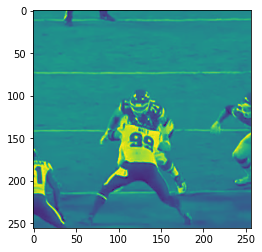

(torch.Size([26, 256, 256]),
 array([ 4.1900e+01,  2.0080e+01,  5.4000e-01,  6.0000e-02,  2.5269e+02,
         2.6231e+02,  9.2000e-01,  9.0000e-01, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00, -1.0000e+00,
        -1.0000e+00, -1.0000e+00,  1.0000e+00], dtype=float32),
 0.0)

In [ ]:
#可以看出图片受到了切割
img, feature, label = MyDataset(train_filtered, valid_aug, 'valid')[1]
# 张量维度移位
plt.imshow(img.permute(1,2,0)[:,:,9])
plt.show()
img.shape, feature, label

In [57]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = timm.create_model(CFG['model'], pretrained=True, num_classes=500, in_chans=13)
        self.mlp = nn.Sequential(
            nn.Linear(18, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            # nn.Linear(64, 64),
            # nn.LayerNorm(64),
            # nn.ReLU(),
            # nn.Dropout(0.2)
        )
        self.fc = nn.Linear(64+500*2, 1)

    def forward(self, img, feature):
        b, c, h, w = img.shape
        img = img.reshape(b*2, c//2, h, w)
        img = self.backbone(img).reshape(b, -1)
        feature = self.mlp(feature)
        y = self.fc(torch.cat([img, feature], dim=1))
        return y

In [58]:
train_,valid_ = train_test_split(train_filtered,test_size=0.1, random_state=42,stratify = train_filtered['contact'])

In [32]:
# train_,valid_ = train_test_split(valid_,test_size=0.5, random_state=42)

In [59]:
train_['contact'].value_counts()

0    536616
1     57881
Name: contact, dtype: int64

In [60]:
valid_['contact'].value_counts()

0    59625
1     6431
Name: contact, dtype: int64

In [61]:
train_.shape,valid_.shape

((594497, 26), (66056, 26))

In [62]:
train_set = MyDataset(train_, train_aug, 'train')
train_loader = DataLoader(train_set, batch_size=CFG['train_bs'], shuffle=True, num_workers=12, pin_memory=True,drop_last=True)
valid_set = MyDataset(valid_, valid_aug, 'test')
valid_loader = DataLoader(valid_set, batch_size=CFG['valid_bs'], shuffle=False, num_workers=12, pin_memory=True)

In [63]:
model = Model()
model.to(device)
model.train()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet50_a1_0-14fe96d1.pth


TimeoutError: [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。

In [ ]:
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()

In [39]:
def evaluate(model, loader_val, *, compute_score=True, pbar=None):
    """
    Predict and compute loss and score
    """
    tb = time.time()
    was_training = model.training
    model.eval()

    loss_sum = 0.0
    n_sum = 0
    y_all = []
    y_pred_all = []

    if pbar is not None:
        pbar = tqdm(desc='Predict', nrows=78, total=pbar)
        
    total= len(loader_val)

    for ibatch,(img, feature, label) in tqdm(enumerate(loader_val),total = total):
        # img, feature, label = [x.to(device) for x in batch]
        img = img.to(device)
        feature = feature.to(device)
        n = label.size(0)
        label = label.to(device)

        with torch.no_grad():
            y_pred = model(img, feature)
        loss = criterion(y_pred.view(-1), label)

        n_sum += n
        loss_sum += n * loss.item()
        
        if pbar is not None:
            pbar.update(len(img))
        
        del loss, img, label
        gc.collect()

    loss_val = loss_sum / n_sum


    ret = {'loss': loss_val,
           'time': time.time() - tb}
    
    model.train(was_training)  # back to train from eval if necessary
    gc.collect()
    return ret

In [40]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
nbatch = len(train_loader)
warmup = CFG['epochs_warmup'] * nbatch
nsteps = CFG['epochs'] * nbatch 

In [41]:
scheduler = CosineLRScheduler(optimizer,
              warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True, # 1 epoch of warmup
              t_initial=(nsteps - warmup), lr_min=1e-6)                # 3 epochs of cosine

In [ ]:
time_val = 0.0
tb = time.time()
best_cv = 0
best_loss = 1e10
print('Epoch   loss        time')
for iepoch in range(CFG['epochs']):
    loss_sum = 0.0
    n_sum = 0
    
    total = len(train_loader)

    # Train
    for ibatch,(img, feature, label) in tqdm(enumerate(train_loader),total = total):
        img = img.to(device)
        feature = feature.to(device)
        n = label.size(0)
        label = label.to(device)
        

        optimizer.zero_grad()

        y_pred = model(img, feature).squeeze(-1)
        
        loss = criterion(y_pred, label)

        loss_train = loss.item()
        loss_sum += n * loss_train
        n_sum += n

        loss.backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG['max_grad_norm'])

        optimizer.step()

        scheduler.step(iepoch * nbatch + ibatch + 1)
        
    val = evaluate(model, valid_loader)
    time_val += val['time']
    loss_train = loss_sum / n_sum
    dt = (time.time() - tb) / 60
    print('Epoch %d %.4f %.4f %.2f min' %
          (iepoch + 1, loss_train, val['loss'],dt))
    if val['loss'] < best_loss:
        best_loss = val['loss']
        # Save model
        ofilename = 'model_pretrain_best_loss.pytorch'
        torch.save(model.state_dict(), ofilename)
        print(ofilename, 'written')
    del val
    gc.collect()

dt = time.time() - tb
print('Training done %.2f min total, %.2f min val' % (dt / 60, time_val / 60))
gc.collect()

Epoch   loss          score   lr


  0%|          | 0/20435 [00:00<?, ?it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

Epoch 1 0.6364 0.5680 2.48 min
